In [378]:
!pip install statsmodels seaborn

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [379]:
import pandas as pd
import geopandas as gpd
import os

from tqdm.notebook import tqdm
import statsmodels.api as spi
from  statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
%matplotlib inline

import seaborn as sns

#for local environment
data_path= os.path.join('data', 'mobility')

In [380]:
def plot_autocorrelation(df, name='default'):
    plt.figure(figsize = (15,4))
    plt.grid(True)

    plt.grid(True)
    plt.xlabel("lags", fontsize = 24)
    plt.ylabel('correlation', fontsize = 24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=16)
    ax= sns.lineplot(data=df);
    #hide legend
    plt.legend([],[], frameon=False)
    plt.tight_layout()
    plt.savefig(os.path.join('figs', f'autocorrelation_{name}.png'))

In [381]:
tour_flows= pd.read_csv(os.path.join(data_path,'agg_flows_with.csv'), index_col=0, parse_dates=['timestamp'])
tour_flows = tour_flows.set_index('index')
tour_flows.head()

,origen,destino,viajes,timestamp,origin_dest
index,,,,,
0,01001_AM,06060_AM,3.841,2020-04-01,01001_AM_06060_AM
1,01001_AM,09056,10.800,2020-04-01,01001_AM_09056
2,01001_AM,09059,27.477,2020-04-01,01001_AM_09059
3,01001_AM,09194_AM,38.666,2020-04-01,01001_AM_09194_AM
4,01001_AM,09439_AM,10.795,2020-04-01,01001_AM_09439_AM


In [382]:
tour_flows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19382811 entries, 0 to 19382810
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   origen       object        
 1   destino      object        
 2   viajes       float64       
 3   timestamp    datetime64[ns]
 4   origin_dest  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 887.3+ MB


In [383]:
i_date = tour_flows['timestamp'].min()
e_date = tour_flows['timestamp'].max()
dates= pd.date_range(i_date,e_date,freq='d')

In [384]:
regions = pd.unique(tour_flows[['origen', 'destino']].values.ravel('K'))

## Plot distribution of incoming touristic flows

In [385]:
incoming_trips = tour_flows.groupby('destino').sum('viajes').reset_index()
incoming_trips.head()

,destino,viajes
0,01001_AM,175823.676
1,01002,32016.230
2,01010_AM,21565.211
3,01031_AM,77410.020
4,01036,103884.803


In [386]:
agg_mun_tourist_gdf= gpd.read_file(os.path.join('data','agg_mun_tourist.geojson'),driver='GeoJSON')
num_incoming_flows = agg_mun_tourist_gdf.merge(incoming_trips, left_on='primary_key', right_on='destino')

In [387]:
num_incoming_flows.head()

,primary_key,area_km2,Viv-total,hotels-total,camps-total,POB20,HOMBRES,MUJERES,Viv-per-area,hotels-per-area,camps-per-area,geometry,destino,viajes
0,01001_AM,359.212,17.0,4.0,1.0,7470,3945,3525,0.047326,0.011135,0.002784,"POLYGON ((-2.46644 42.78842, -2.46983 42.78803...",01001_AM,175823.676
1,01002,96.348,8.0,1.0,1.0,10264,5044,5220,0.083032,0.010379,0.010379,"MULTIPOLYGON (((-2.97525 42.93816, -2.97702 42...",01002,32016.230
2,01010_AM,197.821,17.0,0.0,0.0,5971,3021,2950,0.085936,0.000000,0.000000,"POLYGON ((-3.00076 43.06800, -3.00853 43.06362...",01010_AM,21565.211
3,01031_AM,372.013,50.0,18.0,1.0,7428,3851,3577,0.134404,0.048385,0.002688,"MULTIPOLYGON (((-2.48257 42.49991, -2.48180 42...",01031_AM,77410.020
4,01036,37.559,5.0,1.0,0.0,18118,8868,9250,0.133124,0.026625,0.000000,"POLYGON ((-2.93850 43.13864, -2.93541 43.13658...",01036,103884.803


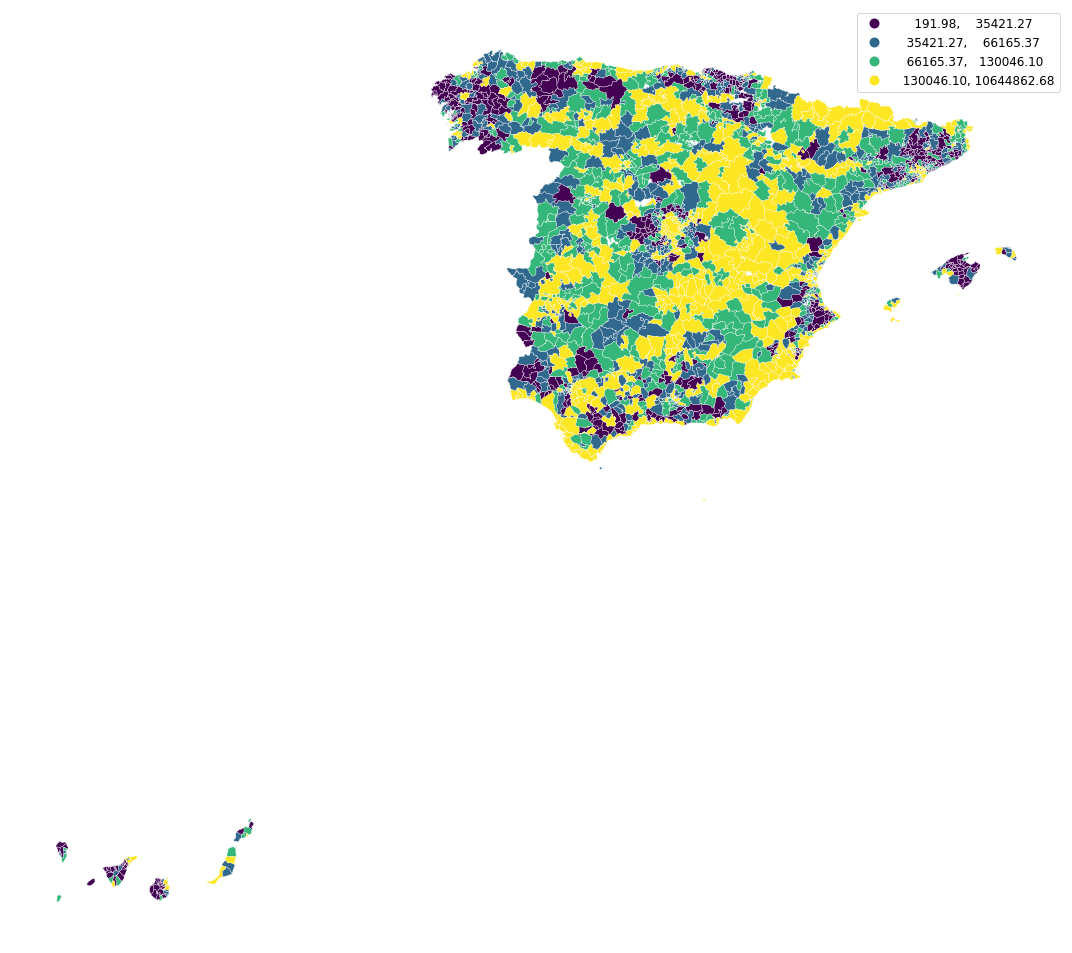

In [388]:
ax=num_incoming_flows.plot('viajes',figsize=(15,15), k=4, scheme='Quantiles',  cmap='viridis', legend=True, legend_kwds={'fontsize': 12});
num_incoming_flows.boundary.plot(ax=ax, color='white', linewidth=0.2);
ax.set_axis_off()
plt.tight_layout()
plt.savefig(os.path.join('figs', 'map_cdr_incoming_trips.png'))

### Plot time series of touristic flows

In [389]:
flows_ts = tour_flows.groupby('timestamp')['viajes'].sum().to_frame()
flows_ts.head()

,viajes
timestamp,
2020-04-01,288569.873
2020-04-02,295664.717
2020-04-03,264106.541
2020-04-04,102316.297
2020-04-05,84076.134


In [390]:
from datetime import datetime as dt
startTime = dt.strptime('01/05/2020', '%d/%m/%Y')
startTime

datetime.datetime(2020, 5, 1, 0, 0)

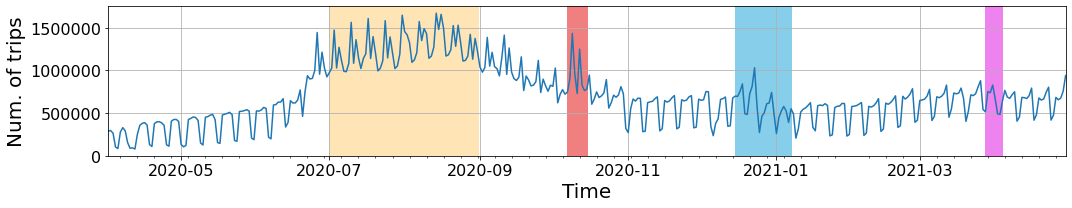

In [391]:
ax= flows_ts.plot(figsize=(15,3), grid=True, legend=False);
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Num. of trips', fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.ticklabel_format(style='plain', axis='y')

#Summer season
startTime = dt.strptime('01/07/2020', '%d/%m/%Y')
endTime = dt.strptime('31/08/2020', '%d/%m/%Y')
start = mdates.date2num(startTime)
end = mdates.date2num(endTime)

width = end-start
rect = Rectangle((start, 0), width, 2000000, color='moccasin')
ax.add_patch(rect)

#October bank holiday
startTime = dt.strptime('07/10/2020', '%d/%m/%Y')
endTime = dt.strptime('15/10/2020', '%d/%m/%Y')
start = mdates.date2num(startTime)
end = mdates.date2num(endTime)

width = end-start
rect = Rectangle((start, 0), width, 2000000, color='lightcoral')
ax.add_patch(rect)

#Christmas holiday
startTime = dt.strptime('15/12/2020', '%d/%m/%Y')
endTime = dt.strptime('07/01/2021', '%d/%m/%Y')
start = mdates.date2num(startTime)
end = mdates.date2num(endTime)

width = end-start
rect = Rectangle((start, 0), width, 2000000, color='skyblue')
ax.add_patch(rect)

#Easter week holiday
startTime = dt.strptime('28/03/2021', '%d/%m/%Y')
endTime = dt.strptime('04/04/2021', '%d/%m/%Y')
start = mdates.date2num(startTime)
end = mdates.date2num(endTime)

width = end-start
rect = Rectangle((start, 0), width, 2000000, color='violet')
ax.add_patch(rect)

locator = mdates.AutoDateLocator(minticks=3)
formatter = mdates.AutoDateFormatter(locator)

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig(os.path.join('figs','ts_cdr_trips.png'))

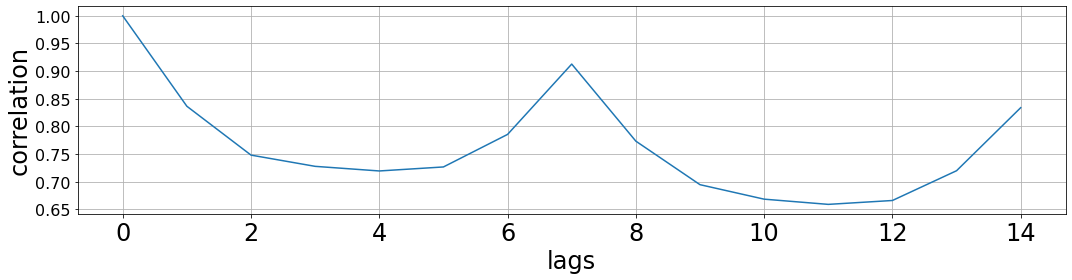

In [392]:
corr_values = spi.tsa.acf(flows_ts.values, nlags = 14,fft = False)
plot_autocorrelation(corr_values, 'cdr')

### Out degrees

In [393]:
all_out_degress= tour_flows.groupby(['timestamp','origen']).size().to_frame()
all_out_degress.columns=['out_degree']
all_out_degress.head()

out_degree
timestamp  origen              
2020-04-01 01001_AM          35
           01002              1
           01010_AM           5
           01031_AM           9
           01036             10

In [394]:
auto_corr={}
for r in tqdm(regions):
    ts= all_out_degress.loc[:,r,:].droplevel('origen')
    corr_values = spi.tsa.acf(ts.values, nlags = 14,fft = False)
    if len(corr_values)== 15:
        auto_corr[r]=corr_values

  0%|          | 0/2238 [00:00<?, ?it/s]

In [395]:
out_auto_corr_df = pd.DataFrame(auto_corr)
out_auto_corr_df.columns = pd.MultiIndex.from_product([['region'],out_auto_corr_df.columns])

In [396]:
out_auto_corr_df.head()

region                                                              \
   01001_AM     01002  01010_AM  01031_AM     01036  01043_AM  01047_AM   
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1  0.462602  0.327873  0.279712  0.692713  0.325951  0.423447  0.556043   
2 -0.040428  0.157250  0.080662  0.598981 -0.102282  0.218558  0.124455   
3 -0.275659  0.120794  0.014599  0.569529 -0.147993  0.163919  0.034077   
4 -0.296596  0.107021  0.093733  0.581077 -0.136327  0.180740  0.025875   

                                 ...                                           \
      01051  01058_AM     01059  ... 3501901_AD     20903     07008     07061   
0  1.000000  1.000000  1.000000  ...   1.000000  1.000000  1.000000  1.000000   
1  0.260939  0.371234  0.595844  ...   0.155201  0.492506  0.147590  0.560357   
2  0.053039 -0.038559  0.289247  ...   0.132799  0.275397 -0.030120  0.471744   
3  0.000510 -0.112789  0.271135  ...   0.140484  0.222592  0.033133  0.464775   
4  0.025746 -0.120126  0.256116  ...   0.007760  0.112392  0.006024  0.453029   

                                                               
   33072_AM     07029     35029     35013     07001  38045_AM  
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1  0.781982 -0.059766  0.429505  0.162359  0.353594  0.592134  
2  0.653326  0.063575  0.452010 -0.024717  0.284065  0.518954  
3  0.525866 -0.124428  0.319491  0.020649  0.010933  0.563399  
4  0.496296 -0.001087  0.339893  0.070833 -0.024662  0.514411  

[5 rows x 2237 columns]

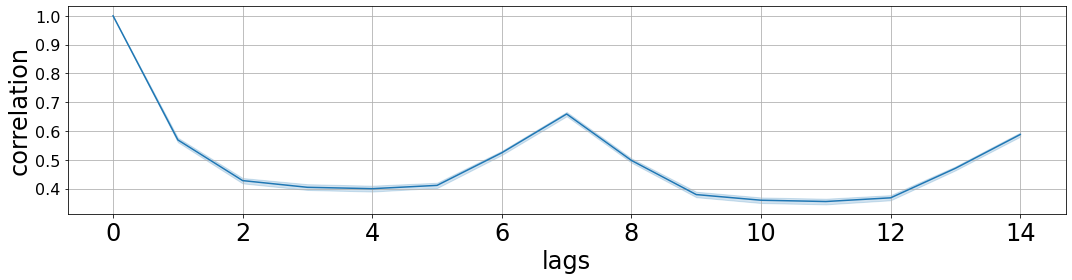

In [397]:
plot_autocorrelation(out_auto_corr_df, 'out_degree')

## In degrees

In [398]:
all_in_degress= tour_flows.groupby(['timestamp','destino']).size().to_frame()
all_in_degress.columns=['in_degree']
all_in_degress.head()

in_degree
timestamp  destino            
2020-04-01 01001_AM         23
           01010_AM          2
           01031_AM         14
           01036            14
           01043_AM          5

In [399]:
auto_corr={}
for r in tqdm(regions):
    ts= all_in_degress.loc[:,r,:].droplevel('destino')
    corr_values = spi.tsa.acf(ts.values, nlags = 14,fft = False)
    if len(corr_values)== 15:
        auto_corr[r]=corr_values
in_auto_corr_df = pd.DataFrame(auto_corr)
in_auto_corr_df.columns = pd.MultiIndex.from_product([['region'],in_auto_corr_df.columns])

  0%|          | 0/2238 [00:00<?, ?it/s]

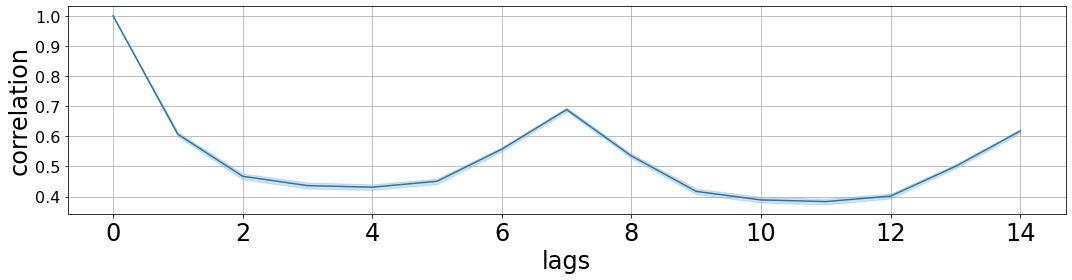

In [400]:
plot_autocorrelation(in_auto_corr_df, 'in_degree')

## Evaluate the evolution of the degrees of each MA

In [401]:
ma_out_degree_df= tour_flows.groupby(['origen', 'timestamp']).size().to_frame().reset_index()
ma_out_degree_df = ma_out_degree_df.rename(columns={0:'degree'})
ma_out_degree_df.head()

,origen,timestamp,degree
0,01001_AM,2020-04-01,35
1,01001_AM,2020-04-02,31
2,01001_AM,2020-04-03,33
3,01001_AM,2020-04-04,17
4,01001_AM,2020-04-05,29


In [402]:
from scipy.stats import entropy

E = ma_out_degree_df.groupby('origen')['degree'].apply(lambda x : entropy(x.value_counts(), base=2)).reset_index()
E.head()

,origen,degree
0,01001_AM,5.640087
1,01002,3.841544
2,01010_AM,3.492719
3,01031_AM,4.948288
4,01036,5.032861


In [403]:
agg_mun_tourist_gdf= gpd.read_file(os.path.join('data','agg_mun_tourist.geojson'),driver='GeoJSON')
agg_mun_tourist_gdf = agg_mun_tourist_gdf.merge(E, left_on='primary_key', right_on='origen')
agg_mun_tourist_gdf.head()

,primary_key,area_km2,Viv-total,hotels-total,camps-total,POB20,HOMBRES,MUJERES,Viv-per-area,hotels-per-area,camps-per-area,geometry,origen,degree
0,01001_AM,359.212,17.0,4.0,1.0,7470,3945,3525,0.047326,0.011135,0.002784,"POLYGON ((-2.46644 42.78842, -2.46983 42.78803...",01001_AM,5.640087
1,01002,96.348,8.0,1.0,1.0,10264,5044,5220,0.083032,0.010379,0.010379,"MULTIPOLYGON (((-2.97525 42.93816, -2.97702 42...",01002,3.841544
2,01010_AM,197.821,17.0,0.0,0.0,5971,3021,2950,0.085936,0.000000,0.000000,"POLYGON ((-3.00076 43.06800, -3.00853 43.06362...",01010_AM,3.492719
3,01031_AM,372.013,50.0,18.0,1.0,7428,3851,3577,0.134404,0.048385,0.002688,"MULTIPOLYGON (((-2.48257 42.49991, -2.48180 42...",01031_AM,4.948288
4,01036,37.559,5.0,1.0,0.0,18118,8868,9250,0.133124,0.026625,0.000000,"POLYGON ((-2.93850 43.13864, -2.93541 43.13658...",01036,5.032861


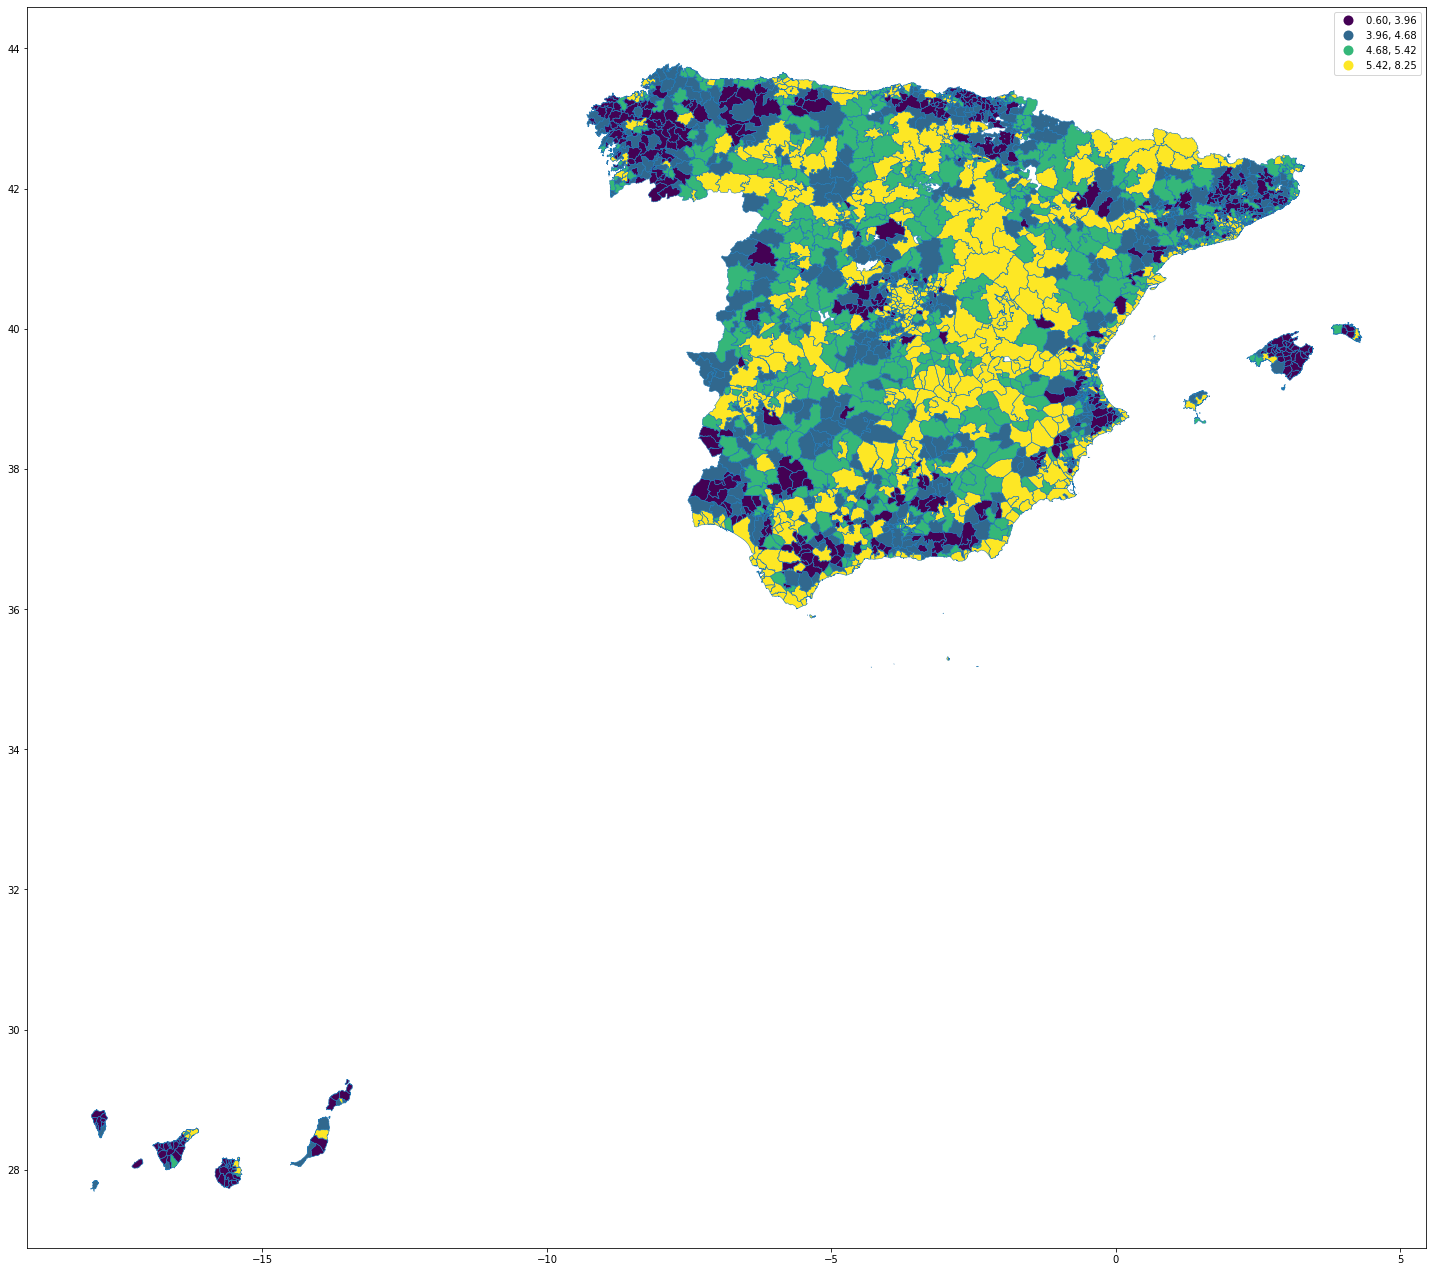

In [404]:
ax=agg_mun_tourist_gdf.boundary.plot(figsize=(20,20),linewidth=0.5);
agg_mun_tourist_gdf.plot('degree',ax=ax, scheme='quantiles', legend=True, k=4);
plt.tight_layout()
plt.savefig(os.path.join('figs', 'degree_entropy.png'))

In [93]:
def calculate_degrees_for_region(r, flows_df, dates):
    in_degree= []
    out_degree=[]
    for d in tqdm(dates, leave=False, desc='Generating degrees for MA...'):
        out_r_date_flow = flows_df[flows_df['origen']==r]
        in_r_date_flow = flows_df[flows_df['destino']==r]
        date_flow= out_r_date_flow[out_r_date_flow['timestamp']==d]
        
        if not date_flow.empty:
            out_degree.append((r, d,date_flow.shape[0]))
        else:
            out_degree.append((d,0))

        date_flow= in_r_date_flow[in_r_date_flow['timestamp']==d]

        if not date_flow.empty:
            in_degree.append((r, d,date_flow.shape[0]))
        else:
            in_degree.append((d,0))

    in_df_ = pd.DataFrame.from_records(in_degree, columns='date in_degree'.split())
    out_df_= pd.DataFrame.from_records(out_degree, columns='date out_degree'.split())
    return in_df_, out_df_

In [256]:
import datetime
from datetime import timedelta

e_date = datetime.datetime.strptime('2021-06-08', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2021-06-03', '%Y-%m-%d')

def generate_days_fn(init_date, final_date):
    
    delta = final_date - init_date       # as timedelta

    target_days = []
    for i in range(delta.days + 1):
        day = init_date + timedelta(days=i)
        target_days.append(day)
    
    return target_days

days_to_study = generate_days_fn(i_date, e_date)

In [257]:
census_zones_gdf = gpd.read_file(os.path.join('data','agg_mun_tourist.geojson'),driver='GeoJSON')

In [258]:
in_dfs = []
out_dfs= []
for c in tqdm(census_zones_gdf['primary_key'].unique(), desc='Loop over MAs...'):
    in_df, out_df = calculate_degrees_for_region(c, tour_flows, days_to_study)
    in_dfs.append(in_df)
    out_dfs.append(out_df)
    
all_in_df = pd.concat(in_dfs, axis=1)
all_out_df = pd.concat(out_dfs, axis=1)

  0%|          | 0/2208 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
all_in_df.head()

### Distribution of trips among areas based on their tourist infrastructure

In [226]:
agg_mun_tourist_gdf['infrastructura-total']= agg_mun_tourist_gdf['Viv-total'] + agg_mun_tourist_gdf['hotels-total'] +agg_mun_tourist_gdf['camps-total']
agg_mun_tourist_gdf['infrastructura-per-area']= agg_mun_tourist_gdf['Viv-per-area'] + agg_mun_tourist_gdf['hotels-per-area'] +agg_mun_tourist_gdf['camps-per-area']
agg_mun_tourist_gdf['infrastructura-total-label']= pd.cut(agg_mun_tourist_gdf['infrastructura-total'], bins=3, labels='L M H'.split())
agg_mun_tourist_gdf['infrastructura-per-area-label']= pd.qcut(agg_mun_tourist_gdf['infrastructura-per-area'], 3, labels='L M H'.split())

agg_mun_tourist_gdf.head()

,primary_key,area_km2,Viv-total,hotels-total,camps-total,POB20,HOMBRES,MUJERES,Viv-per-area,hotels-per-area,camps-per-area,geometry,infrastructura-total,infrastructura-per-area,infrastructura-total-label,infrastructura-per-area-label
0,01001_AM,359.212,17.0,4.0,1.0,7470,3945,3525,0.047326,0.011135,0.002784,"POLYGON ((-2.46644 42.78842, -2.46983 42.78803...",22.0,0.061245,L,L
1,01002,96.348,8.0,1.0,1.0,10264,5044,5220,0.083032,0.010379,0.010379,"MULTIPOLYGON (((-2.97525 42.93816, -2.97702 42...",10.0,0.103790,L,M
2,01010_AM,197.821,17.0,0.0,0.0,5971,3021,2950,0.085936,0.000000,0.000000,"POLYGON ((-3.00076 43.06800, -3.00853 43.06362...",17.0,0.085936,L,M
3,01031_AM,372.013,50.0,18.0,1.0,7428,3851,3577,0.134404,0.048385,0.002688,"MULTIPOLYGON (((-2.48257 42.49991, -2.48180 42...",69.0,0.185477,L,M
4,01036,37.559,5.0,1.0,0.0,18118,8868,9250,0.133124,0.026625,0.000000,"POLYGON ((-2.93850 43.13864, -2.93541 43.13658...",6.0,0.159749,L,M


In [227]:
agg_mun_tourist_gdf.groupby('infrastructura-per-area-label').size()

infrastructura-per-area-label
L    736
M    736
H    736
dtype: int64

In [228]:
agg_mun_tourist_gdf.groupby('infrastructura-per-area-label').size()/ agg_mun_tourist_gdf.shape[0]

infrastructura-per-area-label
L    0.333333
M    0.333333
H    0.333333
dtype: float64

In [229]:
total_flows= tour_flows.groupby(['origen', 'destino'])['viajes'].sum().to_frame().reset_index()

In [230]:
total_flows.head()

,origen,destino,viajes
0,01001_AM,02003,190.127
1,01001_AM,02025,10.811
2,01001_AM,02029_AM,38.957
3,01001_AM,02037,35.949
4,01001_AM,02053_AM,78.352


In [231]:
total_flows_w_infra= total_flows.merge(agg_mun_tourist_gdf[['primary_key', 'infrastructura-total']], left_on='origen', right_on='primary_key')

In [232]:
total_flows_w_infra= total_flows_w_infra.drop(columns='primary_key')
total_flows_w_infra= total_flows_w_infra.rename(columns={'infrastructura-total': 'origin-infra'})

In [233]:
total_flows_w_infra= total_flows_w_infra.merge(agg_mun_tourist_gdf[['primary_key', 'infrastructura-total']], left_on='destino', right_on='primary_key')
total_flows_w_infra= total_flows_w_infra.drop(columns='primary_key')
total_flows_w_infra= total_flows_w_infra.rename(columns={'infrastructura-total': 'dest-infra'})

In [234]:
total_flows_w_infra['dest-infra'] =  total_flows_w_infra['dest-infra']+1
total_flows_w_infra['origin-infra'] =  total_flows_w_infra['origin-infra']+1

In [235]:
total_flows_w_infra['infra_diff']=  total_flows_w_infra['dest-infra']- total_flows_w_infra['origin-infra']
total_flows_w_infra['infra_diff_perc']=  ((total_flows_w_infra['dest-infra']- total_flows_w_infra['origin-infra'])/total_flows_w_infra['origin-infra'])*100

In [236]:
total_flows_w_infra= total_flows_w_infra.dropna()

In [237]:
total_flows_w_infra.head()

,origen,destino,viajes,origin-infra,dest-infra,infra_diff,infra_diff_perc
0,01001_AM,02003,190.127,23.0,177.0,154.0,669.565217
1,01002,02003,7.069,11.0,177.0,166.0,1509.090909
2,01010_AM,02003,7.419,18.0,177.0,159.0,883.333333
3,01031_AM,02003,54.947,70.0,177.0,107.0,152.857143
4,01036,02003,42.540,7.0,177.0,170.0,2428.571429


In [238]:
total_flows_w_infra['infra_diff_perc'].describe()

count    1.799604e+06
mean     6.032307e+02
std      2.888504e+03
min     -9.990476e+01
25%     -7.428571e+01
50%      0.000000e+00
75%      2.714286e+02
max      1.049000e+05
Name: infra_diff_perc, dtype: float64

In [239]:
total_flows_w_infra['origin_label']= pd.qcut(total_flows_w_infra['origin-infra'], 3, labels='L M H'.split())
total_flows_w_infra['dest_label']= pd.qcut(total_flows_w_infra['dest-infra'], 3, labels='L M H'.split())

In [240]:
total_flows_w_infra['diff_label']= pd.cut(total_flows_w_infra['infra_diff'], bins=50)#, labels='A B C'.split())

In [241]:
total_flows_w_infra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1799604 entries, 0 to 1799603
Data columns (total 10 columns):
 #   Column           Dtype   
---  ------           -----   
 0   origen           object  
 1   destino          object  
 2   viajes           float64 
 3   origin-infra     float64 
 4   dest-infra       float64 
 5   infra_diff       float64 
 6   infra_diff_perc  float64 
 7   origin_label     category
 8   dest_label       category
 9   diff_label       category
dtypes: category(3), float64(5), object(2)
memory usage: 115.0+ MB


In [242]:
total_flows_w_infra.head()

,origen,destino,viajes,origin-infra,dest-infra,infra_diff,infra_diff_perc,origin_label,dest_label,diff_label
0,01001_AM,02003,190.127,23.0,177.0,154.0,669.565217,M,H,"(125.88, 167.84]"
1,01002,02003,7.069,11.0,177.0,166.0,1509.090909,L,H,"(125.88, 167.84]"
2,01010_AM,02003,7.419,18.0,177.0,159.0,883.333333,M,H,"(125.88, 167.84]"
3,01031_AM,02003,54.947,70.0,177.0,107.0,152.857143,H,H,"(83.92, 125.88]"
4,01036,02003,42.540,7.0,177.0,170.0,2428.571429,L,H,"(167.84, 209.8]"


In [243]:
flows_totals_df = total_flows_w_infra.groupby('origin_label dest_label'.split())['viajes'].sum().to_frame()
flows_totals_df

viajes
origin_label dest_label              
L            L           1.433052e+07
             M           1.477340e+07
             H           2.287940e+07
M            L           1.633399e+07
             M           1.797841e+07
             H           2.926039e+07
H            L           3.048357e+07
             M           3.557704e+07
             H           7.743058e+07

In [244]:
origin_flows_totals= total_flows_w_infra.groupby(['origin_label'])['viajes'].sum()
origin_flows_totals

origin_label
L    5.198331e+07
M    6.357278e+07
H    1.434912e+08
Name: viajes, dtype: float64

In [245]:
flows_totals_df['viajes'] = flows_totals_df['viajes'] /origin_flows_totals

In [246]:
flows_totals_df

viajes
origin_label dest_label          
L            L           0.275675
             M           0.284195
             H           0.440130
M            L           0.256934
             M           0.282800
             H           0.460266
H            L           0.212442
             M           0.247939
             H           0.539619

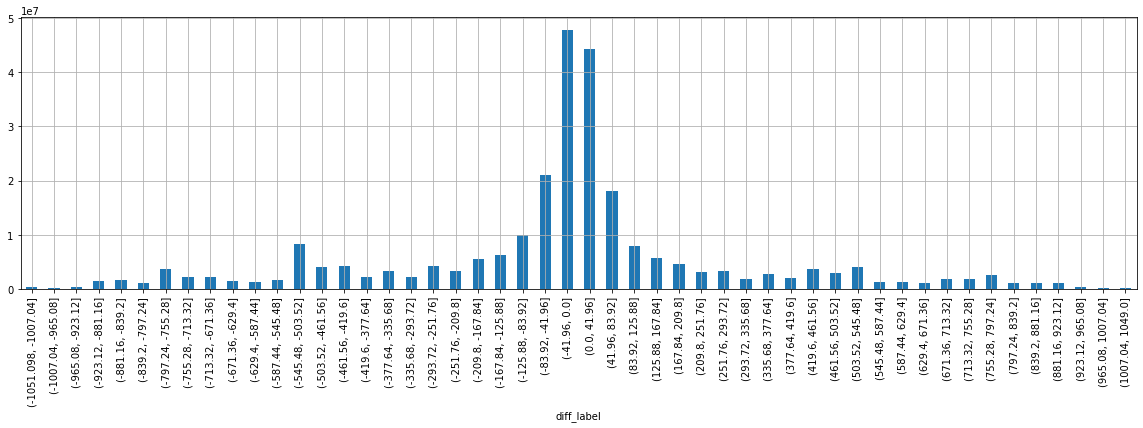

In [247]:
total_flows_w_infra.groupby('diff_label')['viajes'].sum().plot(kind='bar', grid=True, figsize=(20, 5));